In [2]:
from pyscf import gto, scf
#import os
import numpy as np
from matplotlib import pyplot as plt

In [3]:
basis = 'sto6g'

d1 = 3
atom1 = f'''
H 0 0 0
H 0.74 0 0
H 0 {d1} 0
H 0.74 {d1} 0
'''

mol1 = gto.Mole(
verbose=3,
atom=atom1,
basis=basis,
)

mol1.build()
mf1 = scf.RHF(mol1).density_fit()
mf1.kernel()

d2 = 4
atom2 = f'''
H 0 0 0
H 0.74 0 0
H 0 {d2} 0
H 0.74 {d2} 0
'''

mol2 = gto.Mole(
verbose=3,
atom=atom2,
basis=basis,
)

mol2.build()
mf2 = scf.RHF(mol2).density_fit()
mf2.kernel()

print('the rhf energy difference is: ',mf1.e_tot-mf2.e_tot)


WARN: Even tempered Gaussians are generated as DF auxbasis for  H

converged SCF energy = -2.25240339514758

WARN: Even tempered Gaussians are generated as DF auxbasis for  H

converged SCF energy = -2.25289718066489
the rhf energy difference is:  0.0004937855173103856


In [9]:
import importlib
from ad_afqmc import pyscf_interface
importlib.reload(pyscf_interface)

<module 'ad_afqmc.pyscf_interface' from '/home/yichi/research/ad_afqmc/ad_afqmc/pyscf_interface.py'>

In [4]:
from ad_afqmc import pyscf_interface, driver, mpi_jax

mo_file1="mo1.npz"
amp_file1="amp1.npz"
chol_file1="chol1"
pyscf_interface.prep_afqmc(mf1,mo_file=mo_file1,amp_file=amp_file1,chol_file=chol_file1)
mo_file2="mo2.npz"
amp_file2="amp2.npz"
chol_file2="chol2"
pyscf_interface.prep_afqmc(mf2,mo_file=mo_file2,amp_file=amp_file2,chol_file=chol_file2)

# Hostname: YICHI
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
#
# Preparing AFQMC calculation
# Calculating Cholesky integrals
# Decomposing ERI with DF
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (2, 2)
# Number of basis functions: 4
# Number of Cholesky vectors: 36
#
#
# Preparing AFQMC calculation
# Calculating Cholesky integrals
# Decomposing ERI with DF
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (2, 2)
# Number of basis functions: 4
# Number of Cholesky vectors: 36
#


In [5]:
import pickle
import time
from functools import partial
from typing import List, Optional, Union, Sequence

import jax
import jax.numpy as jnp
import numpy as np
from jax import dtypes, jvp, random, vjp

from ad_afqmc import hamiltonian, propagation, sampling, stat_utils, wavefunctions

print = partial(print, flush=True)

options1 = {
    "dt": 0.005,
    "n_eql": 4,
    "n_ene_blocks": 1,
    "n_sr_blocks": 10,
    "n_blocks": 200,
    "n_walkers": 100,
    "seed": 98,
    "walker_type": "rhf",
    "trial": "rhf",
}

options2 = {
    "dt": 0.005,
    "n_eql": 4,
    "n_ene_blocks": 1,
    "n_sr_blocks": 10,
    "n_blocks": 200,
    "n_walkers": 100,
    "seed": 2,
    "walker_type": "rhf",
    "trial": "rhf",
}

In [6]:
afqmc1 = (mpi_jax._prep_afqmc(options1,mo_file=mo_file1,amp_file=amp_file1,chol_file=chol_file1))
e_afqmc1, err_afqmc1 = driver.afqmc(*afqmc1)

# Number of MPI ranks: 1
#
# norb: 4
# nelec: (2, 2)
#
# dt: 0.005
# n_eql: 4
# n_ene_blocks: 1
# n_sr_blocks: 10
# n_blocks: 200
# n_walkers: 100
# seed: 98
# walker_type: rhf
# trial: rhf
# n_prop_steps: 50
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# free_projection: False
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# Equilibration sweeps:
#   Iter        Block energy      Walltime
#     0      -2.252403395e+00     1.66e+00 
#     1      -2.292251110e+00     5.64e+00 
#     2      -2.292726994e+00     8.79e+00 
#     3      -2.293291330e+00     1.02e+01 
#     4      -2.294484615e+00     1.16e+01 
#
# Sampling sweeps:
#  Iter        Mean energy          Stochastic error       Walltime
     0      -2.289402723e+00                -              1.35e+01 
    20      -2.293564048e+00        8.426401222e-04        1.92e+01 
    40      -2.295571031e+00        1.079286784e-03        2.49e+01 
    60      -2.295294641e+00        

In [7]:
afqmc2 = (mpi_jax._prep_afqmc(options2,mo_file=mo_file2,amp_file=amp_file2,chol_file=chol_file2))
e_afqmc2, err_afqmc2 = driver.afqmc(*afqmc2)

# Number of MPI ranks: 1
#
# norb: 4
# nelec: (2, 2)
#
# dt: 0.005
# n_eql: 4
# n_ene_blocks: 1
# n_sr_blocks: 10
# n_blocks: 200
# n_walkers: 100
# seed: 2
# walker_type: rhf
# trial: rhf
# n_prop_steps: 50
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# free_projection: False
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# Equilibration sweeps:
#   Iter        Block energy      Walltime
#     0      -2.252897181e+00     4.84e-01 
#     1      -2.289426804e+00     2.32e+00 
#     2      -2.297527552e+00     3.77e+00 
#     3      -2.293185949e+00     5.17e+00 
#     4      -2.298487902e+00     7.30e+00 
#
# Sampling sweeps:
#  Iter        Mean energy          Stochastic error       Walltime
     0      -2.307496786e+00                -              7.92e+00 
    20      -2.298304772e+00        2.503498456e-03        1.84e+01 
    40      -2.296136328e+00        1.412527578e-03        2.59e+01 
    60      -2.295340798e+00        9

In [8]:
afqmc_en_diff = e_afqmc1 - e_afqmc2
afqmc_en_diff_err = np.sqrt(err_afqmc1**2+err_afqmc2**2)
print(f'the afqmc energy difference is {afqmc_en_diff}, error is {afqmc_en_diff_err}')

the afqmc energy difference is 0.0006677572816236044, error is 0.0005406872247259238


In [9]:
from dataclasses import dataclass
from functools import partial
from typing import Any, Tuple

import jax
import jax.numpy as jnp
from jax import checkpoint, jit, lax, random

from ad_afqmc import linalg_utils
from ad_afqmc.hamiltonian import hamiltonian
from ad_afqmc.propagation import propagator
from ad_afqmc.wavefunctions import wave_function

sampler_eq = sampling.sampler(n_prop_steps=50, n_ene_blocks=5, n_sr_blocks=10)

def init_prop(ham_data, ham, prop, trial, wave_data, options, MPI):
    comm = MPI.COMM_WORLD
    #size = comm.Get_size()
    rank = comm.Get_rank()
    seed = options["seed"]
    #neql = options["n_eql"]
    init_walkers: Optional[Union[List, jax.Array]] = None
    trial_rdm1 = trial.get_rdm1(wave_data)
    if "rdm1" not in wave_data:
        wave_data["rdm1"] = trial_rdm1
    ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
    ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)
    prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
    prop_data["key"] = random.PRNGKey(seed + rank)
    prop_data["n_killed_walkers"] = 0
    print(f"# initial energy: {prop_data['e_estimate']:.9e}")
    
    return prop_data, ham_data

def en_samples(prop_data,ham_data,prop,trial,wave_data):
    energy_samples = jnp.real(
        trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    )
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]) > jnp.sqrt(2.0 / prop.dt),
        prop_data["e_estimate"],
        energy_samples,
    )
    return energy_samples

def block_en_weight(prop_data,ham_data,prop,trial,wave_data):

    energy_samples = en_samples(prop_data,ham_data,prop,wave_data,trial)

    block_weight = jnp.sum(prop_data["weights"])
    block_energy = jnp.sum(energy_samples * prop_data["weights"]) / block_weight
    return block_energy, block_weight

def field_block_scan(
        prop_data: dict,
        fields,
        ham_data: dict,
        prop: propagator,
        trial: wave_function,
        wave_data: dict,
        ) -> Tuple[dict, Tuple[jax.Array, jax.Array]]:
    """Block scan function for a given field"""
    _step_scan_wrapper = lambda x, y: sampler_eq._step_scan(
        x, y, ham_data, prop, trial, wave_data
    )
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)
    prop_data["n_killed_walkers"] += prop_data["weights"].size - jnp.count_nonzero(
        prop_data["weights"]
    )
    prop_data = prop.orthonormalize_walkers(prop_data)
    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)

    block_energy,_ = block_en_weight(prop_data,ham_data,prop,wave_data,trial)
    prop_data["pop_control_ene_shift"] = (
        0.9 * prop_data["pop_control_ene_shift"] + 0.1 * block_energy
    )
    return prop_data

def cs_block_scan(
        prop_data1: dict,
        ham_data1: dict,
        prop1: propagator,
        trial1: wave_function,
        wave_data1: dict,
        prop_data2: dict,
        ham_data2: dict,
        prop2: propagator,
        trial2: wave_function,
        wave_data2: dict):
    '''correlated sampling of two blocks over the same field'''
    prop_data1["key"], subkey1 = random.split(prop_data1["key"])
    fields = random.normal(
        subkey1,
        shape=(
            sampler_eq.n_prop_steps,
            prop1.n_walkers,
            ham_data1["chol"].shape[0],
        )
    )
    prop_data1 = field_block_scan(prop_data1,fields,ham_data1,prop1,trial1,wave_data1)
    prop_data2 = field_block_scan(prop_data2,fields,ham_data2,prop2,trial2,wave_data2)

    return prop_data1, prop_data2, fields

def ucs_block_scan(
        prop_data1: dict,
        ham_data1: dict,
        prop1: propagator,
        trial1: wave_function,
        wave_data1: dict,
        prop_data2: dict,
        ham_data2: dict,
        prop2: propagator,
        trial2: wave_function,
        wave_data2: dict):
    '''correlated sampling of two blocks over the same field'''
    prop_data1["key"], subkey1 = random.split(prop_data1["key"])
    fields1 = random.normal(
        subkey1,
        shape=(
            sampler_eq.n_prop_steps,
            prop1.n_walkers,
            ham_data1["chol"].shape[0],
        )
    )
    prop_data1 = field_block_scan(prop_data1,fields1,ham_data1,prop1,trial1,wave_data1)

    prop_data2["key"], subkey2 = random.split(prop_data2["key"])
    fields2 = random.normal(
        subkey2,
        shape=(
            sampler_eq.n_prop_steps,
            prop2.n_walkers,
            ham_data2["chol"].shape[0],
        )
    )
    prop_data2 = field_block_scan(prop_data2,fields2,ham_data2,prop2,trial2,wave_data2)

    return prop_data1, prop_data2, fields1, fields2

In [10]:
ham_data1, ham1, prop1, trial1, wave_data1, sampler1, observable1, options1, MPI \
    = mpi_jax._prep_afqmc(options1,mo_file=mo_file1,amp_file=amp_file1,chol_file=chol_file1)
ham_data2, ham2, prop2, trial2, wave_data2, sampler2, observable2, options2, MPI \
    = mpi_jax._prep_afqmc(options2,mo_file=mo_file2,amp_file=amp_file2,chol_file=chol_file2)

prop_data1, ham_data1 = init_prop(ham_data1, ham1, prop1, trial1, wave_data1, options1, MPI)
prop_data2, ham_data2 = init_prop(ham_data2, ham2, prop2, trial2, wave_data2, options2, MPI)

steps = np.arange(0, 10, 1)
weight_cwalker_en1 = [0]*10
weight_cwalker_en2 = [0]*10
cwalker_en_diff = [0]*10
weight_cwalker_en_diff_err = [0]*10
for n in steps:
    prop_data1,prop_data2,fields = cs_block_scan(prop_data1,ham_data1,prop1,trial1,wave_data1,prop_data2,ham_data2,prop2,trial2,wave_data2)
    energy_samples1 = en_samples(prop_data1,ham_data1,prop1,trial1,wave_data1)
    energy_samples2 = en_samples(prop_data2,ham_data2,prop2,trial2,wave_data2)
    norm_weight1 = prop_data1["weights"]/jnp.sum(prop_data1["weights"])
    norm_weight2 = prop_data2["weights"]/jnp.sum(prop_data2["weights"])
    weight_cwalker_en1 = energy_samples1*norm_weight1
    weight_cwalker_en2 = energy_samples2*norm_weight2
    weight_cwalker_en_diff = weight_cwalker_en1 - weight_cwalker_en2
    weight_cwalker_en_diff_err[n] = weight_cwalker_en_diff.std()
    cwalker_en_diff[n] = sum(weight_cwalker_en_diff)

# Number of MPI ranks: 1
#
# norb: 4
# nelec: (2, 2)
#
# dt: 0.005
# n_eql: 4
# n_ene_blocks: 1
# n_sr_blocks: 10
# n_blocks: 200
# n_walkers: 100
# seed: 98
# walker_type: rhf
# trial: rhf
# n_prop_steps: 50
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# free_projection: False
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# Number of MPI ranks: 1
#
# norb: 4
# nelec: (2, 2)
#
# dt: 0.005
# n_eql: 4
# n_ene_blocks: 1
# n_sr_blocks: 10
# n_blocks: 200
# n_walkers: 100
# seed: 2
# walker_type: rhf
# trial: rhf
# n_prop_steps: 50
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# free_projection: False
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# initial energy: -2.252403395e+00
# initial energy: -2.252897181e+00


In [11]:
ham_data1, ham1, prop1, trial1, wave_data1, sampler1, observable1, options1, MPI \
    = mpi_jax._prep_afqmc(options1,mo_file=mo_file1,amp_file=amp_file1,chol_file=chol_file1)
ham_data2, ham2, prop2, trial2, wave_data2, sampler2, observable2, options2, MPI \
    = mpi_jax._prep_afqmc(options2,mo_file=mo_file2,amp_file=amp_file2,chol_file=chol_file2)

prop_data1, ham_data1 = init_prop(ham_data1, ham1, prop1, trial1, wave_data1, options1, MPI)
prop_data2, ham_data2 = init_prop(ham_data2, ham2, prop2, trial2, wave_data2, options2, MPI)

steps = np.arange(0, 10, 1)
#weight_cwalker_en1 = [0]*10
#weight_cwalker_en2 = [0]*10
walker_en_diff = [0]*10
weight_walker_en_diff_err = [0]*10
for n in steps:
    prop_data1,prop_data2,_,_ = ucs_block_scan(prop_data1,ham_data1,prop1,trial1,wave_data1,prop_data2,ham_data2,prop2,trial2,wave_data2)
    energy_samples1 = en_samples(prop_data1,ham_data1,prop1,trial1,wave_data1)
    energy_samples2 = en_samples(prop_data2,ham_data2,prop2,trial2,wave_data2)
    norm_weight1 = prop_data1["weights"]/jnp.sum(prop_data1["weights"])
    norm_weight2 = prop_data2["weights"]/jnp.sum(prop_data2["weights"])
    weight_walker_en1 = energy_samples1*norm_weight1
    weight_walker_en2 = energy_samples2*norm_weight2
    weight_walker_en_diff = weight_walker_en1 - weight_walker_en2
    weight_walker_en_diff_err[n] = weight_walker_en_diff.std()
    walker_en_diff[n] = sum(weight_walker_en_diff)

# Number of MPI ranks: 1
#
# norb: 4
# nelec: (2, 2)
#
# dt: 0.005
# n_eql: 4
# n_ene_blocks: 1
# n_sr_blocks: 10
# n_blocks: 200
# n_walkers: 100
# seed: 98
# walker_type: rhf
# trial: rhf
# n_prop_steps: 50
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# free_projection: False
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# Number of MPI ranks: 1
#
# norb: 4
# nelec: (2, 2)
#
# dt: 0.005
# n_eql: 4
# n_ene_blocks: 1
# n_sr_blocks: 10
# n_blocks: 200
# n_walkers: 100
# seed: 2
# walker_type: rhf
# trial: rhf
# n_prop_steps: 50
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# free_projection: False
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# initial energy: -2.252403395e+00
# initial energy: -2.252897181e+00


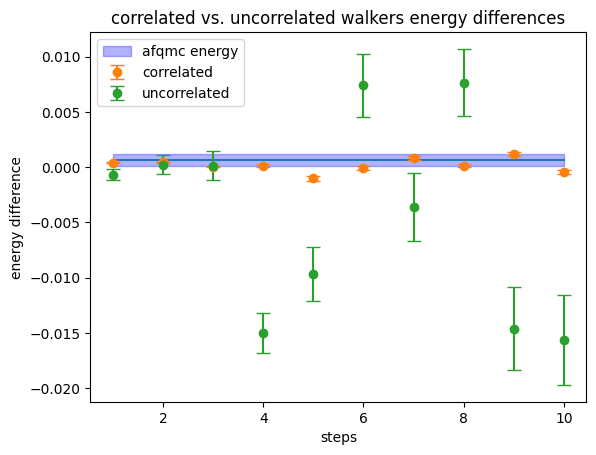

In [12]:
x_steps = np.linspace(1,10,100)
afqmc_en = np.array([afqmc_en_diff]*len(x_steps))
afqmc_lw = afqmc_en-afqmc_en_diff_err
afqmc_up = afqmc_en+afqmc_en_diff_err
plt.plot(x_steps,afqmc_en)
plt.fill_between(x_steps, afqmc_lw, afqmc_up, color='blue', alpha=0.3, label='afqmc energy')
plt.errorbar(steps+1,cwalker_en_diff,yerr=weight_cwalker_en_diff_err, fmt='o', capsize=5,label='correlated')
plt.errorbar(steps+1,walker_en_diff,yerr=weight_walker_en_diff_err, fmt='o', capsize=5,label='uncorrelated')
plt.xlabel('steps')
plt.ylabel('energy difference')
plt.title('correlated vs. uncorrelated walkers energy differences')
plt.legend()
plt.show()